<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

# Install

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.features import Manifold

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline

# Generalized Linear Models
* Use probability distributions as building blocks for a model
* Three components to a GLM:
  * Linear Predictor - Linear combination of parameters and explanatory variables (b0 + b1 * X)
  * Probability Distribution - Generates the observed variable (y)
  * Link Function - "Links" the linear predictor to the distribution

## Linear Regression
* Uses the identity link function
* Uses normal distribution as the probability distribution
* Because the normal distribution is used, we have expectations about the residuals & constant variance

![](https://miro.medium.com/max/244/1*D_2gt4WHDJEfb_hpZ1eoKQ.png)

## Logistic Regression
* Uses the logit function as the link function 
* Uses the (binomial) bernoulli distribution to generate y



![](https://miro.medium.com/max/320/1*h5AM_ez965bZysPtSm4YLQ.png)


# Data

In [3]:
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [4]:
breast_cancer_df = pd.DataFrame(breast_cancer['data'], columns=breast_cancer['feature_names'])
breast_cancer_df['TARGET'] = breast_cancer['target']
breast_cancer_df.columns = [col.replace(' ', '_') for col in breast_cancer_df.columns]
breast_cancer_df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,TARGET
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# EDA

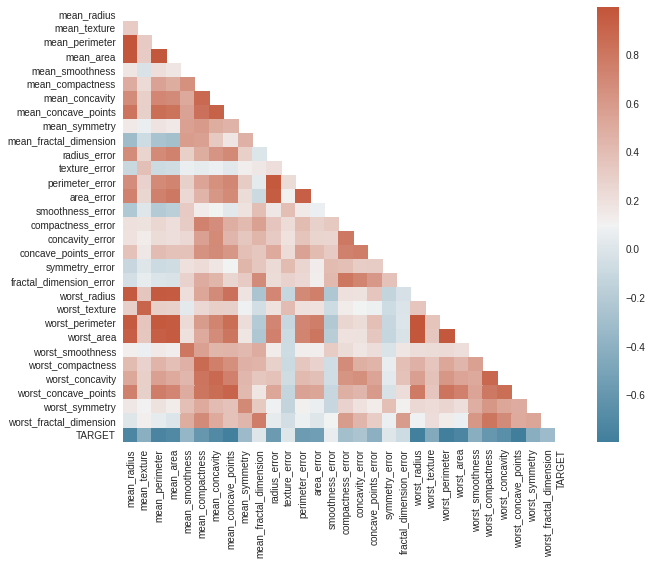

In [5]:
corr = breast_cancer_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap)

# Visualization

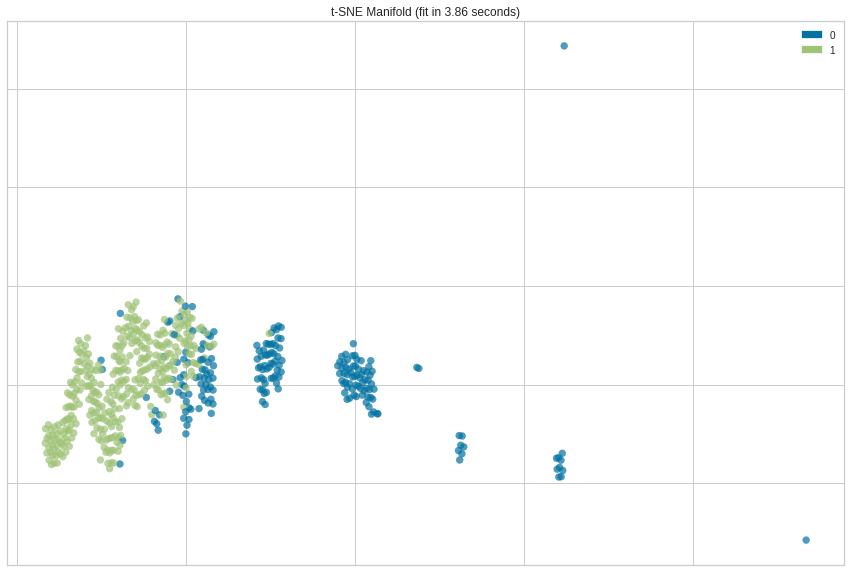

In [6]:
X = breast_cancer_df.drop('TARGET', axis=1)
y = breast_cancer_df['TARGET']
plt.figure(figsize=(15,10))
visualizer = Manifold(manifold='tsne', target='discrete')
visualizer.fit_transform(X, y)
visualizer.poof()

# Classification

## Correlated Features
* Knock out several highly correlated features from EDA

In [7]:
SELECT = [
    #'mean_radius', 
    'mean_texture', 
    #'mean_perimeter', 
    'mean_area',
    'mean_smoothness', 
    'mean_compactness', 
    #'mean_concavity',
    'mean_concave_points', 
    'mean_symmetry', 
    'mean_fractal_dimension',
    #'radius_error', 
    'texture_error', 
    #'perimeter_error', 
    'area_error',
    'smoothness_error', 
    'compactness_error', 
    'concavity_error',
    'concave_points_error', 
    'symmetry_error', 
    'fractal_dimension_error',
    #'worst_radius', 
    #'worst_texture', 
    #'worst_perimeter', 
    #'worst_area',
    'worst_smoothness', 
    'worst_compactness', 
    'worst_concavity',
    #'worst_concave_points', 
    'worst_symmetry', 
    'worst_fractal_dimension'   
]

## Test Train
* 80/20 split 
* Stratify on the outcome

In [8]:
X = breast_cancer_df[SELECT]
y = breast_cancer_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1337)

# Pipeline
* Simple / Standard looking Pipeline

In [9]:
featuresNumeric = X.columns.tolist()
transformerNumeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

featuresCategorical = []
transformerCategorical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
        ('numeric',     transformerNumeric,     featuresNumeric),
        ('categorical', transformerCategorical, featuresCategorical)
])

# GLM

## Model

In [10]:
logistic = LogisticRegression(solver='liblinear')
logPipe = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])
logPipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                           

## Predictions

In [11]:
preds = logPipe.predict(X_test)
proba = logPipe.predict_proba(X_test)
print('Score Train {:.3f}'.format(logPipe.score(X_train, y_train)))
print('Score Test  {:.3f}'.format(logPipe.score(X_test, y_test)))

Score Train 0.941
Score Test  0.958


In [12]:
predDF = pd.DataFrame(proba, columns=['Probability False', 'Probability True'])
predDF['Predicted Class'] = preds
predDF.head()

,Probability False,Probability True,Predicted Class
0,0.999997,0.000003,0
1,0.010556,0.989444,1
2,0.197324,0.802676,1
3,0.999023,0.000977,0
4,0.992236,0.007764,0


## Threshold
* Defaulted to 0.5, but can be set from 0.0 to 1.0 depending on "cost" of error
* Precision: An increase in precision is a reduction in the number of false positives
* Recall: An increase in recall decreases the likelihood that we miss a positive class
* F1 Score: The F1 score is the harmonic mean between precision and recall
* Queue Rate: This metric describes the percentage of instances that must be reviewed. 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/u

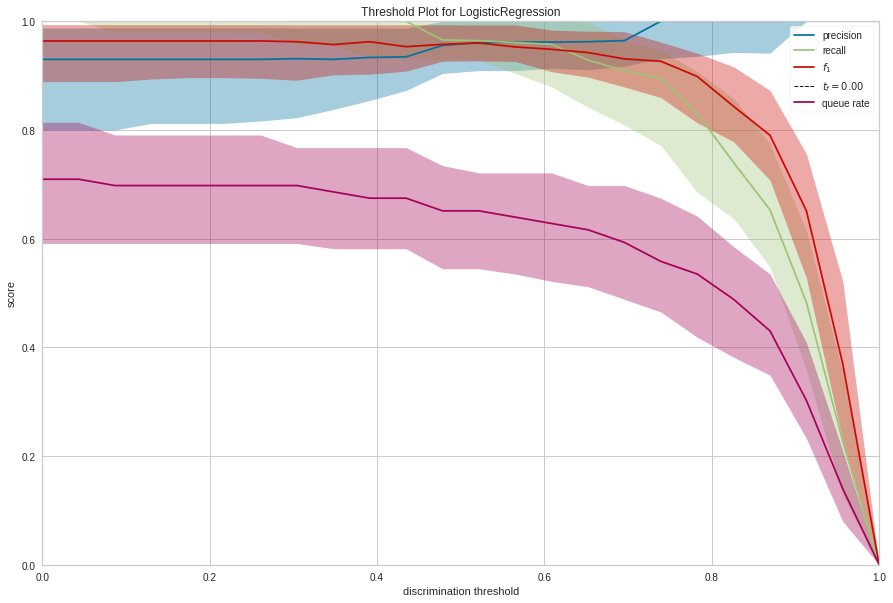

In [13]:
plt.figure(figsize=(15,10))
visualizer = DiscriminationThreshold(logPipe)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.poof()     # Draw/show/poof the data

## Errors

In [14]:
print('Test Accuracy = {:.3f}'.format(logPipe.score(X_test, y_test)))

Test Accuracy = 0.958


### Log Loss
* Common loss objective function
* Quantifies the accuracy of a classifier by penalising false classifications
* Minimising the Log Loss == Maximising the classifier accuracy 
* Log Loss penalizes erroneous predictions made with high confidence more than those with low confidence
 * Class = 1 & Predict Prob Class 1 = 0.5, Log Loss == 1
 * Class = 1 & Predict Prob Class 1 = 0.0, Log Loss == Very Large (+Infinity)
 * Class = 1 & Predict Prob Class 1 = 1.0, Log Loss == Very Small (Approaching 0)

![](https://my-static-images.s3.us-east-2.amazonaws.com/article_3_log_loss.png)

In [15]:
print('Log Loss: {:.3f}'.format(log_loss(y_test, preds)))

Log Loss: 1.449


### Confusion Matrix

In [16]:
cm = confusion_matrix(y_test, preds)
print(cm)

[[51  2]
 [ 4 86]]


### Classification Report

In [17]:
rpt = classification_report(y_test, preds)
print(rpt)

              precision    recall  f1-score   support

           0       0.93      0.96      0.94        53
           1       0.98      0.96      0.97        90

    accuracy                           0.96       143
   macro avg       0.95      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



### AUC - ROC Curve
* https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
* ROC curve measures performance on classification problem at various thresholds
* ROC is a probability curve plotted with TPR against FPR
* AUC represents degree or measure of separability
 * Total Area = 1.0
 * Random = 0.5
* Higher AUC equates to a better the model 

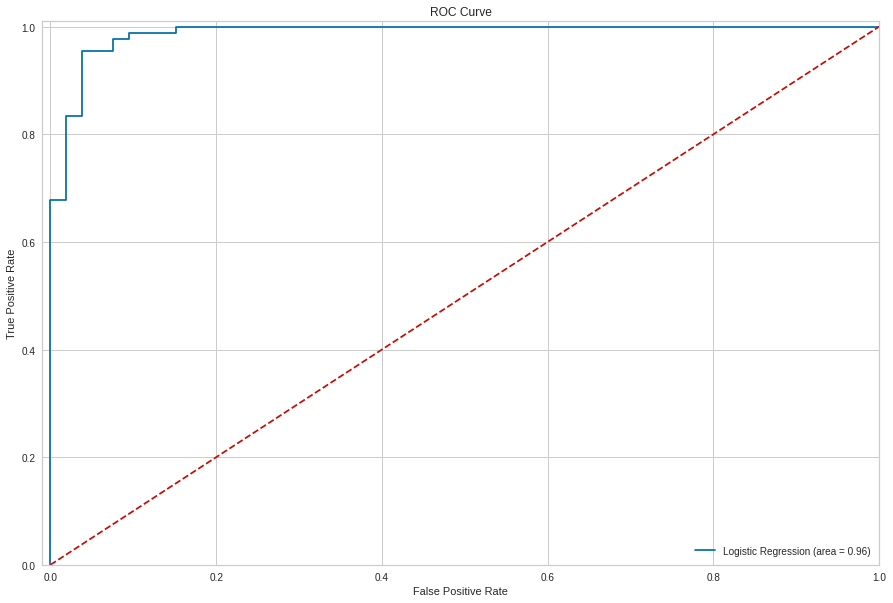

In [18]:
logit_roc_auc = roc_auc_score(y_test, preds)
fpr, tpr, thresholds = roc_curve(y_test, proba[:,1])
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.style.use('seaborn-whitegrid')
plt.show()

### AUC

In [19]:
print('AUC: {:.3f}'.format(logit_roc_auc))

AUC: 0.959


### Cohen's Kappa
* Measures the agreement between two raters
  * Our model
  * A baseline
* Baseline is found by always guessing the majority class
* In our example we have 90 Positives out of 143 in test (~ 63%)
* Intuition : If our accuracy were .63, our Cohen's Kappa would = 0
* Scores
  * < 0 = No agreement
  * 0.01 - 0.2 = Slight
  * 0.2 - 0.4  = Fair
  * 0.4 - 0.6  = Moderate
  * 0.6 - 0.8  = Substantial
  * 0.8 - 1.0  = Almost Perfect

$$score = 1 - \frac{(1 - accuracy)}{(1 - baseline)}$$

In [20]:
print("Cohen's Kappa    : {:.3f}".format(cohen_kappa_score(y_test, logPipe.predict(X_test))))

Cohen's Kappa    : 0.911


# Yellowbrick Visualizations

## Confusion

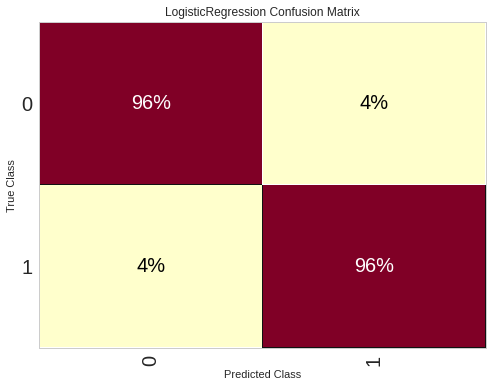

In [21]:
plt.figure(figsize=(8,6))
visualizer = ConfusionMatrix(logPipe, classes=[0,1], percent=True, fontsize=20)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

## Classification Report

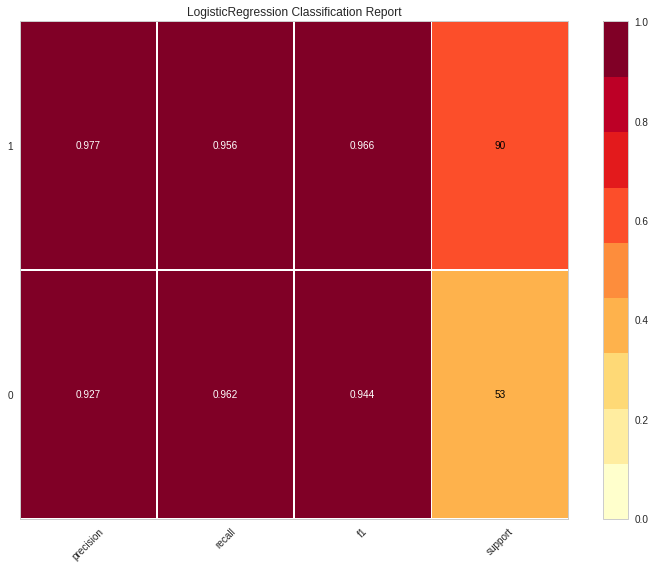

In [22]:
plt.figure(figsize=(10,8))
visualizer = ClassificationReport(logPipe, classes=[0,1], support=True)
visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

## ROC Curve

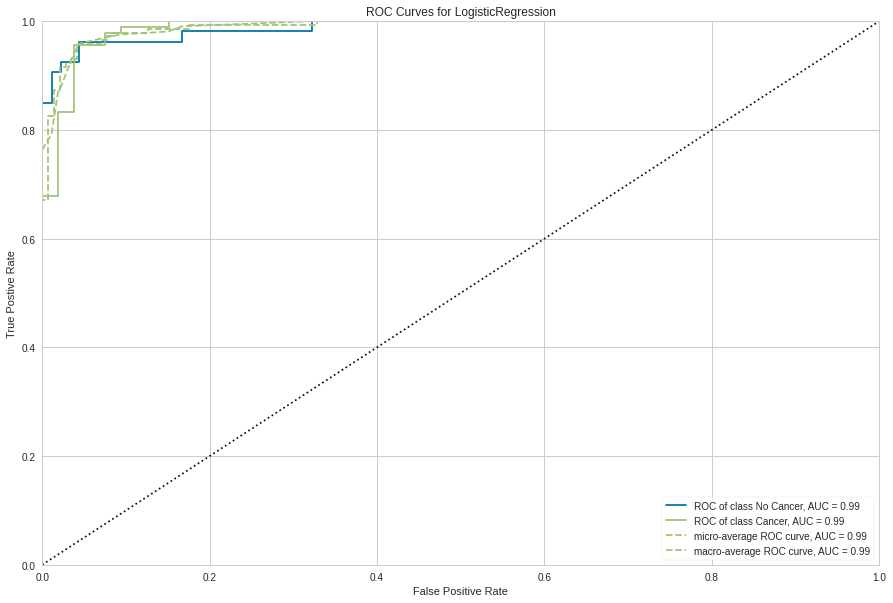

In [23]:
plt.figure(figsize=(15,10))
visualizer = ROCAUC(logPipe, classes=['No Cancer', 'Cancer'])
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()             

## Class Prediction Error

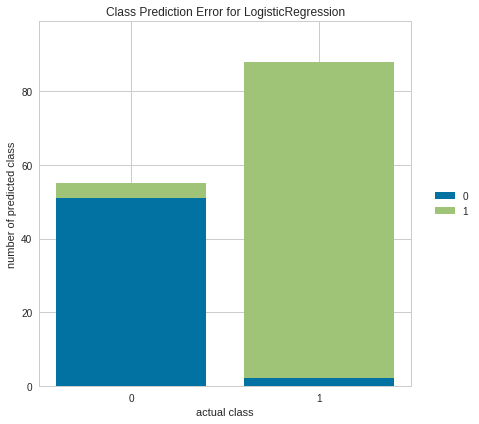

In [24]:
plt.figure(figsize=(8,6))
visualizer = ClassPredictionError(logPipe, classes=[0,1])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()

# Interpretation

## 20 Feature Model

In [48]:
model = sm.Logit(y_train, X_train)
# model = sm.GLM(y_train, X_train, family=sm.families.Binomial()) # Alternative Definition
result = model.fit()
print(result.summary2())
preds20 = result.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.052181
         Iterations 23
                                Results: Logit
Model:                    Logit                Pseudo R-squared:     0.921     
Dependent Variable:       TARGET               AIC:                  84.4581   
Date:                     2021-02-11 13:49     BIC:                  165.5469  
No. Observations:         426                  Log-Likelihood:       -22.229   
Df Model:                 19                   LL-Null:              -281.44   
Df Residuals:             406                  LLR p-value:          7.5852e-98
Converged:                1.0000               Scale:                1.0000    
No. Iterations:           23.0000                                              
-------------------------------------------------------------------------------
                          Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
--------------------------------------------------

## Coefficients
* Coefficients affect Log Odds - Exponentiate to see change
* 1 Unit change of coefficient relates to Log-Odds of Cancer 
* Coefficient changes are not linear!
* Exponentiate coefficient to find the change in Odds
* Slope is instructive (Negative is a reduction in odds)

## Observations
* There are several extremely large coefficients and serveral with large p-values (intervals including 0).
 * fractal_dimension_error 2,434
 * smoothness_error        819
 * mean_fractal_dimension  673
* We could be overfitting or including too many features in the model
* We should look at:
 * Feature selection
 * Regularization

# Assumptions
* Linearity in the logit - b0 + b1*x1 + b2*x2 ...
* Binariness - all y values are binary
* Independence - y1...yn are independent

Note:
* Homoskedasticity is not required
* Normal residuals is not required in the Bernoulli distribution


## Goodness of Fit
* Deviance is a common measure
* Deviance is defined as the difference of likelihoods between the fitted and saturated model
  * D = -2 * log lik(B) + 2 * log lik(saturated)
* Where likelihood of saturated model is exactly 1 resulting in:
  * D = -2 * log lik(B)
* A good baseline comparison is to use the intercept model, called null deviance
  * D = -2 * log lik (B0)
* Finally, to compare we look at the ratio of the deviance between the fitted model to the null model
* R2 = 1 - D(fitted) / D(null)
  * R2 falls between 0 and 1
  * As R2 approaches 1, the fit is best
  * In the fit of the 20 feature model, 1 - (-281.44 / -22.229) = 0.921
* R2 is NOT the same as in linear regression
  * A ratio expressing how close is the fit to being best or worst 
  * Not related to correlation
  * Always decreases as additional regressors are added

## Multicollinearity
* Can hide significant variables
* Can change sign of variables
* Can increase the variability of the estimate
* Fight with stepwise regression and variable inflation fators

## Variable Inflation Factors
* The model has high VIF

In [26]:
variables = model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

vifDF = pd.DataFrame()
vifDF['Coefficient'] = model.exog_names
vifDF['VIF'] = vif
vifDF['Flag'] = np.where(vifDF.VIF > 5, True, False)
vifDF

,Coefficient,VIF,Flag
0,mean_texture,39.197976,True
1,mean_area,31.936662,True
2,mean_smoothness,354.737981,True
3,mean_compactness,101.826212,True
4,mean_concave_points,48.985429,True
5,mean_symmetry,168.472187,True
6,mean_fractal_dimension,476.319744,True
7,texture_error,12.525101,True
8,area_error,5.797101,True
9,smoothness_error,28.779625,True


# Feature Selection
* Find the top features to keep using either:
  * Recursive Feature Elimation (Backward Elimination)
  * Forward Selection

## Scoring Top N Features

In [27]:
metricAUC     = []
metricF1      = []
metricLogLoss = []
for features in range(20):
    rfe = RFE(logistic, features + 1, 1)
    rfe = rfe.fit(X_train, y_train)
    features_bool = np.array(rfe.support_)
    features = np.array(X.columns)
    topFeatures = features[features_bool].tolist()
    
    model = sm.Logit(y_train, X_train[topFeatures])
    result = model.fit()
    preds = result.predict(X_test[topFeatures])

    fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
    metricAUC.append(auc(fpr, tpr))
    metricF1.append(f1_score(y_test, preds > 0.5))
    metricLogLoss.append(log_loss(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.676617
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.611109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.285709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.209117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143605
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143503
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.142554

## Top N AUC

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

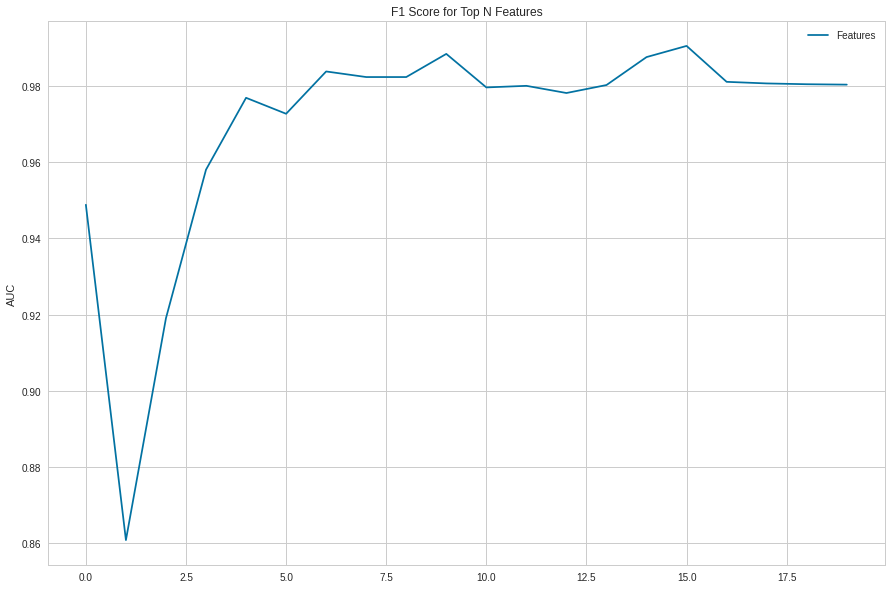

In [28]:
pd.DataFrame(metricAUC, columns=['Features']).plot(figsize=(15,10))
plt.title('F1 Score for Top N Features')
plt.ylabel('AUC')
plt

## Top N F1 Score

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

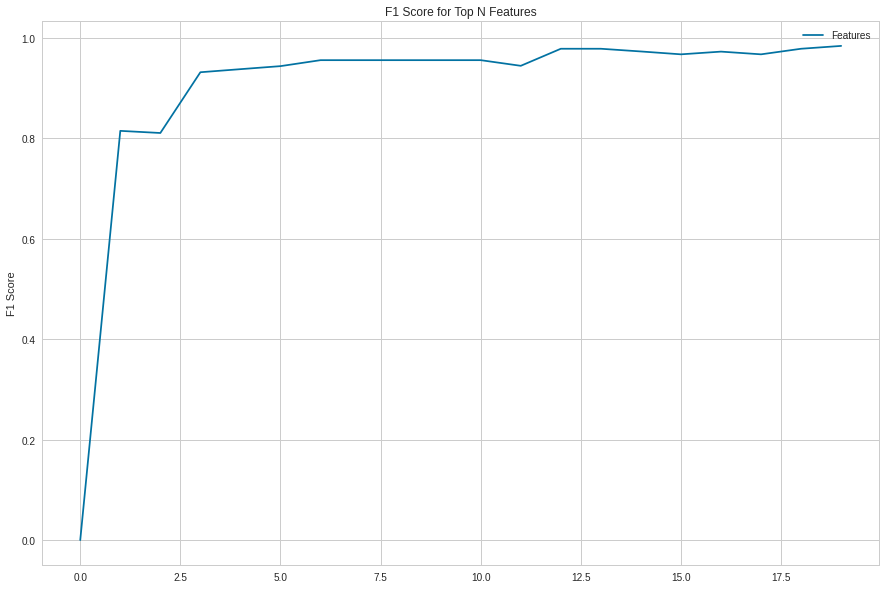

In [29]:
pd.DataFrame(metricF1, columns=['Features']).plot(figsize=(15,10))
plt.title('F1 Score for Top N Features')
plt.ylabel('F1 Score')
plt

## Top N Log Loss

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

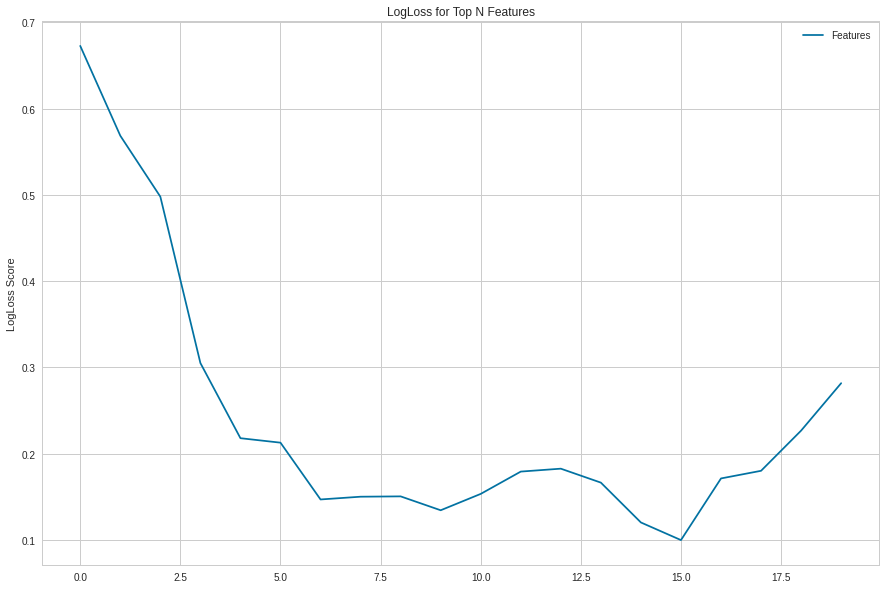

In [30]:
pd.DataFrame(metricLogLoss, columns=['Features']).plot(figsize=(15,10))
plt.title('LogLoss for Top N Features')
plt.ylabel('LogLoss Score')
plt

## Top 15 Features

In [31]:
logistic = LogisticRegression(solver='liblinear')
logPipeRFE = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])

In [32]:
rfe = RFE(logistic, 15, 1)
rfe = rfe.fit(X_train, y_train)
features_bool = np.array(rfe.support_)
features = np.array(X.columns)
topFeatures = features[features_bool].tolist()
topFeatures

['mean_texture',
 'mean_smoothness',
 'mean_compactness',
 'mean_concave_points',
 'mean_symmetry',
 'mean_fractal_dimension',
 'texture_error',
 'area_error',
 'compactness_error',
 'concavity_error',
 'symmetry_error',
 'worst_compactness',
 'worst_concavity',
 'worst_symmetry',
 'worst_fractal_dimension']

In [33]:
model = sm.Logit(y_train, X_train[topFeatures])
result = model.fit()
print(result.summary2())
preds15 = result.predict(X_test[topFeatures])

Optimization terminated successfully.
         Current function value: 0.063058
         Iterations 13
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.905     
Dependent Variable:      TARGET              AIC:                 83.7252   
Date:                    2021-02-11 13:45    BIC:                 144.5418  
No. Observations:        426                 Log-Likelihood:      -26.863   
Df Model:                14                  LL-Null:             -281.44   
Df Residuals:            411                 LLR p-value:         1.0626e-99
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          13.0000                                            
----------------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
----------------------------------------------------------------------------
mean

## Comparison
* The 15 feature model includes several features that have a high p-value
* High p-value or intervals stretching across zero potentially could be removed
* Alternatively, we could look to regularize the coefficients

In [34]:
result_df = pd.DataFrame(columns=['LogLoss', 'AUC'])

### 20 Feature Model

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, preds20, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, preds20)

result_df.loc['20 Feature Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.980
Log Loss: 0.282


In [36]:
preds20_class = preds20 > 0.5
print(classification_report(y_test, preds20_class))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        53
           1       0.98      0.99      0.98        90

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143



### 15 Feature Model

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, preds15, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, preds15)

result_df.loc['15 Feature Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.988
Log Loss: 0.120


In [38]:
preds15_class = preds15 > 0.5
print(classification_report(y_test, preds15_class))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.97      0.98      0.97        90

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.97      0.96       143



# Regularization

In [39]:
logistic = LogisticRegression(solver='liblinear')
regPipe = Pipeline([
    ('preprocess', preprocessor),
    ('logistic', logistic)
])

param_grid = {
    'logistic__penalty' : ['l1'],
    'logistic__C' : np.logspace(-4, 4, 20)
}

clf = GridSearchCV(regPipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished


In [40]:
best_clf.best_params_

{'logistic__C': 29.763514416313132, 'logistic__penalty': 'l1'}

## Model

In [41]:
model = sm.Logit(y_train, X_train)
result = model.fit_regularized(method='l1', alpha=1.0, L1_wt=best_clf.best_params_['logistic__C'])
print(result.summary2())
predsReg = result.predict(X_test)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3087672496298156
            Iterations: 89
            Function evaluations: 99
            Gradient evaluations: 89
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.623     
Dependent Variable:    TARGET             AIC:                224.4079  
Date:                  2021-02-11 13:45   BIC:                248.7345  
No. Observations:      426                Log-Likelihood:     -106.20   
Df Model:              5                  LL-Null:            -281.44   
Df Residuals:          420                LLR p-value:        1.3850e-73
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        89.0000                                          
------------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
---------------

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


## Errors

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, predsReg, pos_label=1)
area_under_curve = auc(fpr, tpr)
logloss = log_loss(y_test, predsReg)

result_df.loc['Regularized Model'] = [logloss, area_under_curve]

print('AUC:      {:.3f}'.format(area_under_curve))
print('Log Loss: {:.3f}'.format(logloss))

AUC:      0.969
Log Loss: 0.233


In [43]:
predsReg_class = predsReg > 0.5
print(classification_report(y_test, predsReg_class))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        53
           1       0.93      0.93      0.93        90

    accuracy                           0.92       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143



# Results

In [44]:
result_df.sort_values('LogLoss')

,LogLoss,AUC
15 Feature Model,0.120154,0.987631
Regularized Model,0.232784,0.968973
20 Feature Model,0.281644,0.980398


# Advice & Tips
* Advantages:
 * Computationally efficient
 * Interpretable
 * Does not require features scaling (good for optimization though)
 * Does not require tuning
 * Easy to regularize
* Logistic Regression works best when:
 * Remove features that are highly correlated with eachother
 * Remove features that have little relationship with the dependent variable
* Downsides
 * Can be outperformed by complex models
 * Can’t solve non-linear problems since it has a linear decision surface / boundary
* Practical Tips
 * Consider feature selection
 * Test Regularization L1 & L2
 * Use statsmodel for interpreation